### Vehicle Detection and Tracking

In [ ]:
#Decleration: Some of the fucntions i used are from Udacity self driving car lectures

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label


In [5]:
#Read in cars and notcars

images = glob.glob('./data/vehicles/**/*.png',recursive=True)
cars = []

for image in images:
    cars.append(image)

images = glob.glob('./data/non-vehicles/**/*.png',recursive=True)
notcars = []

for image in images:
    notcars.append(image)


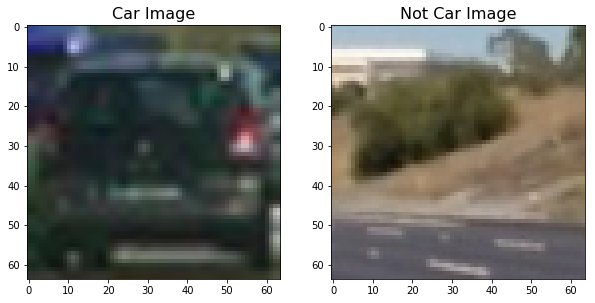

In [6]:
# Visulaize random Car and no-Car images from tarining dataset
car_img = mpimg.imread(cars[300])
not_car_img = mpimg.imread(notcars[300])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(not_car_img)
ax2.set_title('Not Car Image', fontsize=16)
print(' ')

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



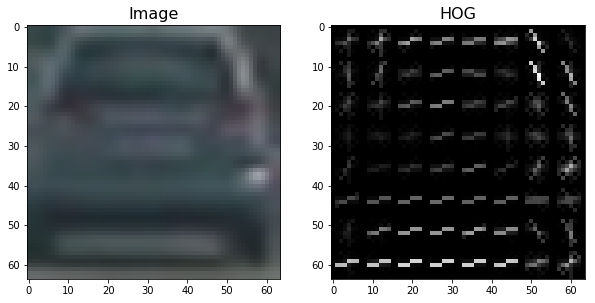

In [8]:
# Visualize HOG image
image = mpimg.imread(cars[10])
#plt.imshow(image)
img = np.copy(image)
hog_feat,hog_img = get_hog_features(img[:,:,0],9,8,8,True,True)
#plt.imshow(hog_img,cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(img)
ax1.set_title('Image', fontsize=16)
ax2.imshow(hog_img, cmap='gray')
ax2.set_title('HOG', fontsize=16)
print(' ')

In [9]:
print(hog_feat)

[0.2557333  0.16092997 0.09371155 0.10780576 0.41338279 0.08290246
 0.         0.02066116 0.0224899  0.44017599 0.31467071 0.12925074
 0.28592136 0.45058403 0.03706197 0.0243351  0.04327359 0.05579648
 0.01303124 0.04332971 0.14750201 0.19648814 1.13681797 0.05868048
 0.0123374  0.01257355 0.         0.         0.         0.0107572
 0.16244999 1.084255   0.1584521  0.         0.         0.
 0.0019663  0.         0.00292121 0.03046451 1.14062251 0.32749727
 0.08549661 0.         0.01297066 0.03835503 0.01528289 0.02645677
 0.13624381 1.22915567 0.47453078 0.20953638 0.05503023 0.02766569
 0.0422475  0.02317402 0.01129484 0.03272704 0.02352068 0.15528275
 0.39604909 1.03739836 0.40999995 0.06435744 0.0040363  0.
 0.013507   0.05499791 0.0362563  0.08112164 0.11711345 0.12918951
 0.45203043 0.02308156 0.0552781  0.06380698 0.08852466 0.03408312
 0.04224431 0.08484521 0.25090742 0.34374513 0.46801117 0.11703592
 0.04161847 0.05401745 0.00468619 0.06138775 0.01080246 0.06427275
 0.01538485 

In [10]:
# Define a function to compute binned color features 
# Use cv2.resize().ravel() to create the feature vector
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
     # Return the feature vector
    return np.hstack((color1, color2, color3))

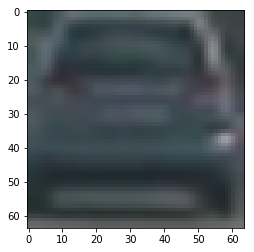

In [11]:
# Test Bin Spatial on an image
image = mpimg.imread(cars[10])
plt.imshow(image)
img = np.copy(image)
bin_feat = bin_spatial (img)


In [12]:
print(bin_feat)

[0.21568628 0.20784314 0.19509804 ... 0.39313728 0.4166667  0.42745098]


(array([130., 441., 688., 823., 601., 238.,  96.,  34.,  15.,   6.]),
 array([0.12156864, 0.16882354, 0.21607844, 0.26333334, 0.31058824,
        0.35784314, 0.40509804, 0.45235294, 0.49960784, 0.54686274,
        0.59411764]),
 <a list of 10 Patch objects>)

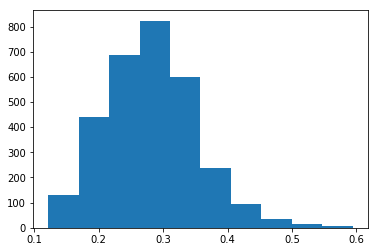

In [13]:
plt.hist(bin_feat)

In [14]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features




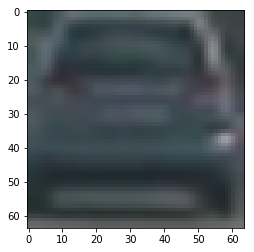

In [15]:
# Test Color hist on an image
image = mpimg.imread(cars[10])
plt.imshow(image)
img = np.copy(image)
color_feat = color_hist (img)

In [16]:
print(color_feat)

[4096    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 4096    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 4096    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


(array([93.,  0.,  3.]),
 array([   0.        , 1365.33333333, 2730.66666667, 4096.        ]),
 <a list of 3 Patch objects>)

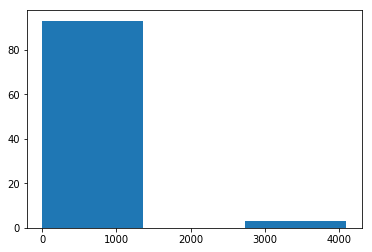

In [17]:
plt.hist(color_feat,bins=3)

In [18]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=8, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    


In [19]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



In [20]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [21]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=8, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)





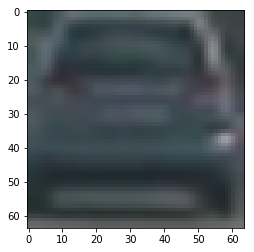

In [22]:
# Test single image features function
image = mpimg.imread(cars[10])
plt.imshow(image)
img = np.copy(image)
All_feat = single_img_features(img)

In [23]:
print(All_feat)

[0.21568628 0.20784314 0.19509804 ... 0.03931392 0.00895453 0.        ]


In [24]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    


In [43]:
#parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 8 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [320, 720] # Min and max in y to search in slide_window()


In [26]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 8 cells per block
Feature vector length: 4896
19.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9865


In [27]:
# save the model to disk
#filename = 'SVC_emil.sav'
#pickle.dump(svc, open(filename, 'wb'))

In [28]:
#load the model from disk
#filename = 'SVC_emil.sav'
#loaded_model = pickle.load(open(filename, 'rb'))
#print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [29]:
#loaded_model

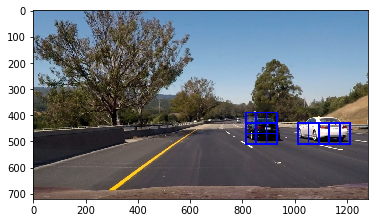

In [30]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
img=image

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255


x_ranges = [[None, None],[32, None],[412, 1280]]
y_ranges = [[400, 600],[400, 600],[390, 540]]
window_sizes = [(128, 218),(96, 96),(80, 80)]
overlaps = [(0.5, 0.5),(0.5, 0.5),(0.5, 0.5)]
windows = []
    
windows = slide_window(image, x_start_stop=x_ranges[2], y_start_stop=y_ranges[2], 
                xy_window=window_sizes[2], xy_overlap=overlaps[2])

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)                       


window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6) 
###




plt.imshow(window_img)



 
[((812, 390), (892, 470)), ((852, 390), (932, 470)), ((812, 430), (892, 510)), ((852, 430), (932, 510)), ((1012, 430), (1092, 510)), ((1052, 430), (1132, 510)), ((1092, 430), (1172, 510)), ((1132, 430), (1212, 510))]


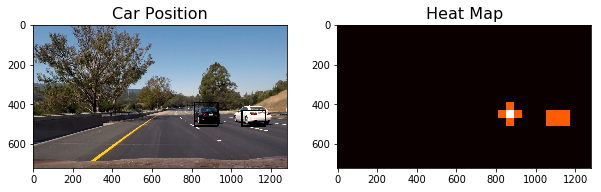

In [31]:

box_list = hot_windows
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(draw_img)
ax1.set_title('Car Position', fontsize=16)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=16)
print(' ')
print(hot_windows)

In [32]:
#Adanced Method

In [33]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


[((744, 496), (840, 592)), ((768, 400), (864, 496)), ((792, 400), (888, 496)), ((816, 400), (912, 496)), ((816, 424), (912, 520)), ((816, 448), (912, 544)), ((816, 472), (912, 568)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((864, 400), (960, 496)), ((888, 400), (984, 496)), ((984, 400), (1080, 496)), ((1032, 400), (1128, 496)), ((1032, 424), (1128, 520)), ((1056, 400), (1152, 496)), ((1080, 424), (1176, 520)), ((1104, 400), (1200, 496)), ((1104, 424), (1200, 520)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520))]


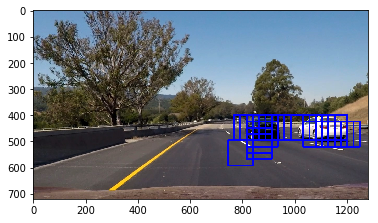

In [63]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    hot_win=[]
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                if xbox_left >= 620:
                    hot_win.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img ,hot_win
    
ystart = 400
ystop = 656
scale = 1.5
img = mpimg.imread('test_images/test6.jpg')  
out_img,hot_win = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
print(hot_win)


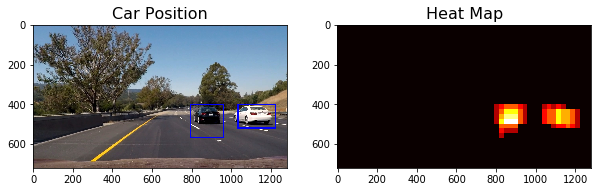

In [64]:
box_list = hot_win
heat = np.zeros_like(img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(draw_img)
ax1.set_title('Car Position', fontsize=16)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=16)
print(' ')

In [65]:
#Pipeline
def process_image(img):
        
    out_img,hot_win = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list = hot_win
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

           
    #result = out_img
    result =draw_img
         
        
    return result

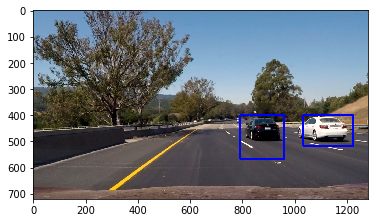

In [66]:
#Test the pipeline on an image
img = mpimg.imread('test_images/test6.jpg')

result = process_image(img)

plt.imshow(result)

In [67]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [57]:
#Test video

video_output = 'test_video_output.mp4'
video_input = VideoFileClip("test_video.mp4")
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:31<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 33.7 s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output.mp4"))

In [59]:
#Project video

video_output = 'project_video_output.mp4'
video_input = VideoFileClip("project_video.mp4")
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [23:36<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 23min 38s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_output.mp4"))

In [ ]:
#Improvements:
#Add diffrent size sliding windows with diffrent scales
#Save history of the found hot windowsé boxes

In [106]:
#Decleration: I got help for creating the following class from my colleagues on Udacity. 

#Define a class to hot windows from video farmes
class Vehicle_Detect():
    def __init__(self):
        # history of hot windows from last n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # Delete old hot windows
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]


In [131]:
# Advanced Pipeline
def process_video(img):

    
    hot_win1=[]
    hot_win2=[]
    hot_win3=[]
    hot_win4=[]
    hot_win5=[]
    hot_win6=[]
    hot_win7=[]
    hot_win8=[]
    
    box_list=[]
     
    ystart = 400
    ystop = 464
    scale = 1.0
    out_img,hot_win1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
          
    
    ystart = 416
    ystop = 480
    scale = 1.0
    out_img,hot_win2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
    ystart = 400
    ystop = 496
    scale = 1.5
    out_img,hot_win3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_win.append(hot_win)
    
    
    ystart = 432
    ystop = 528
    scale = 1.5
    out_img,hot_win4 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    ystart = 400
    ystop = 528
    scale = 2.0
    out_img,hot_win5 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    ystart = 432
    ystop = 560
    scale = 2.0
    out_img,hot_win6 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
     
    
    
    ystart = 400
    ystop = 596
    scale = 3.5
    out_img,hot_win7 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    ystart = 464
    ystop = 660
    scale = 3.5
    out_img,hot_win8 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    box_list = hot_win1 + hot_win2 + hot_win3 + hot_win4 + hot_win5 + hot_win6 + hot_win7 + hot_win8
    
         
    # add detected hot windows to the box list
        
    if len(box_list) > 0:
        det.add_rects(box_list)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    for rect_set in det.prev_rects:
        heat = add_heat(heat, rect_set)
    heat = apply_threshold(heat, 1 + len(det.prev_rects)//2)
    
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
          
    
    result =draw_img
    
    return result
     


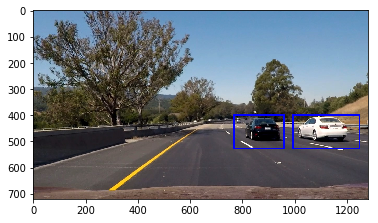

In [132]:
#Test the pipeline on an image
img = mpimg.imread('test_images/test6.jpg')
det = Vehicle_Detect()

result = process_video(img)

plt.imshow(result)

In [133]:
#Test video
det = Vehicle_Detect()
video_output = 'test_video_output.mp4'
video_input = VideoFileClip("test_video.mp4")
processed_video = video_input.fl_image(process_video)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:39<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 42 s


In [134]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("test_video_output.mp4"))

In [135]:
#Project video
det = Vehicle_Detect()
video_output = 'project_video_output.mp4'
video_input = VideoFileClip("project_video.mp4")
processed_video = video_input.fl_image(process_video)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [29:40<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 29min 42s


In [136]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_output.mp4"))